# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Python imports

In [55]:
import sys
import os
import hashlib
import pickle
import time
from urllib.request import urlretrieve
import urllib
import random
from zipfile import ZipFile
from tqdm import tqdm

import imutils


import tensorflow as tf
from tensorflow.contrib.layers import flatten

import numpy as np
import pandas as pd

#import skimage.data
#import skimage.transform
from   skimage.transform import resize

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec


import math
import cv2
import time as time
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from sklearn.utils import shuffle

import prettytensor as pt
from PIL import Image
import time
from datetime import timedelta

%matplotlib inline
print('All modules imported.')

All modules imported.


---
## Step 0: Load The Data

In [56]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
testing_file =  "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [57]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = train['features'].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = max(train['labels']) - min(train['labels']) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


In [58]:
c_train, c_test = train['coords'], test['coords']

### Extra Summary & Exploration 

Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


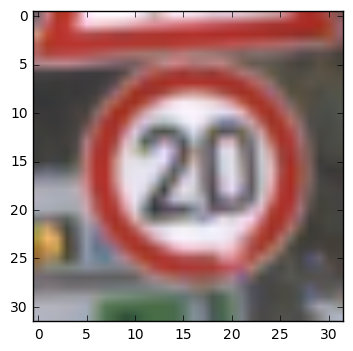

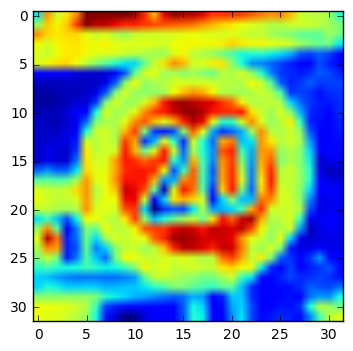

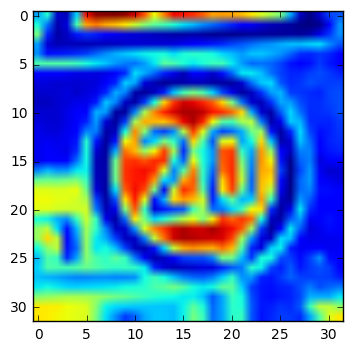

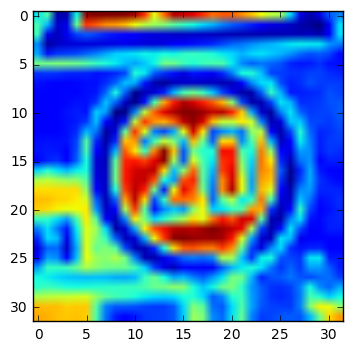

In [59]:
n_test = len(X_test)
print("Number of testing examples =", n_test)
f15 = train['features'][15]
image_shape = train['features'][15].shape
print("Image data shape =", image_shape)
n_classes = max(train['labels']) - min(train['labels']) + 1
print("Number of classes =", n_classes)
fig,ax = plt.subplots(1)
ax.imshow(f15);
plt.figure()
plt.imshow(f15[:, :, 0])
plt.figure()
plt.imshow(f15[:, :, 1])
plt.figure()
plt.imshow(f15[:, :, 2])

In [60]:
## Useful methods for plotting 
# Crop images to min length
def crop_image(img):
    """Make any image a square image.
    Parameters
    ----------
    img : np.ndarray
        Input image to crop, assumed at least 2d.
    Returns
    -------
    crop : np.ndarray
        Cropped image.
    """
    size = np.min(img.shape[:2])
    extra = img.shape[:2] - size
    crop = img
    for i in np.flatnonzero(extra):
        crop = np.take(crop, extra[i] // 2 + np.r_[:size], axis=i)
    return crop
## Compositing 
def composite(images, saveto='com_montage.png'):
    #separated by 1 pixel borders. and type numpy.ndarray
        
    # Crop every image to a square
    images = [crop_image(img_i) for img_i in images]

    # Then resize the square image to 100 x 100 pixels
    images = [resize(img_i, (100, 100)) for img_i in images]

    # Finally make our list of 3-D images a 4-D array with the first dimension the number of images:
    images = np.array(images).astype(np.float32)
    
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    if len(images.shape) == 4 and images.shape[3] == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5
    else:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    plt.imsave(arr=m, fname=saveto)
    return m

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

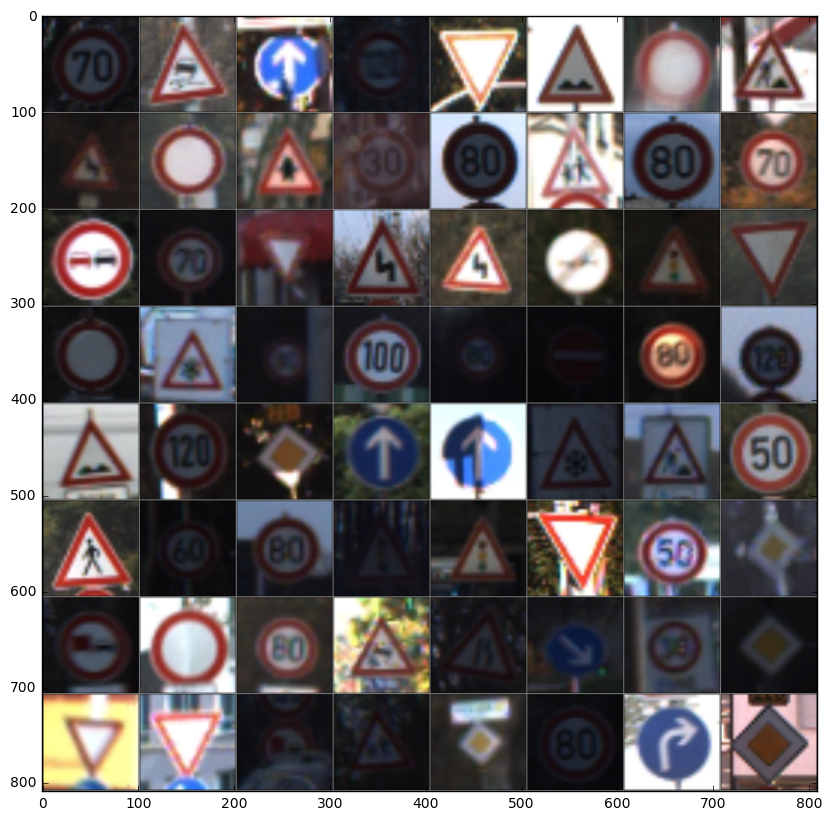

In [61]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# Display 64 random Images

# Using coords array lets draw a bounding box around the sign in the image
x1 = train['coords'][0][0]
y1 = train['coords'][0][1]
x2 = train['coords'][0][2]
y2 = train['coords'][0][3]
#Creating rectangular patch
rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()
indices = np.random.permutation(X_train.shape[0])
images_idx = indices[:64]
imgs = X_train[images_idx,:]
plt.figure(figsize=(10, 10))
plt.imshow(composite(imgs)); 

In [62]:
# Display images with labels
def img_lavels(images, labels, save_fname):
    unique_labels = set(labels)
    fig = plt.figure(figsize=(20, 20))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()
    
    # Now we can save it to a numpy array and save the image to a file
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.imsave(arr=data, fname=save_fname)


No of unique Labels: 43
Total Images: 39209


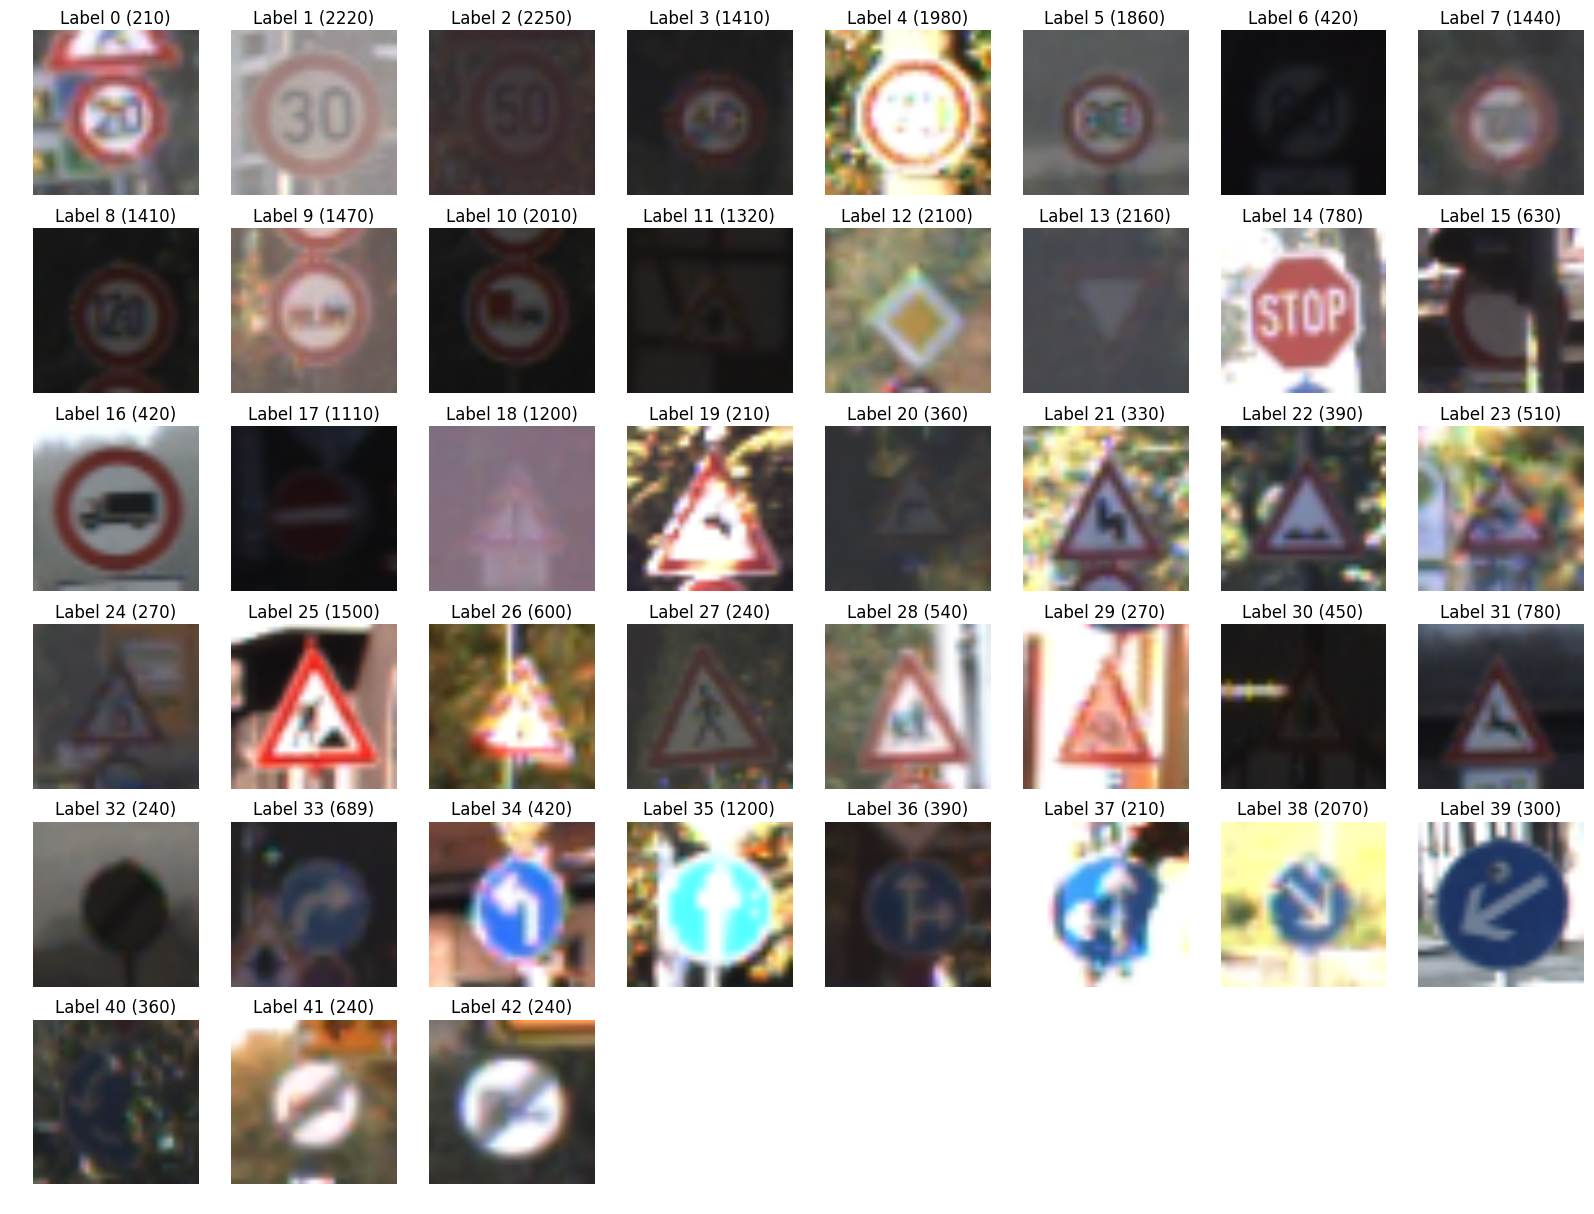

In [63]:
#UNIQUE NOS
images = X_train
labels = train['labels'].tolist()

print("\nNo of unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

img_lavels(images, labels, "unq_labels.png")

In [64]:
# Images in a class
def img_class(images, label, save_fname):
    limit = 48 
    fig = plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels[start:].index(label+1)
    for image in images[start:end][:limit]:
        plt.subplot(4,12, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()   
    
    # Now we can save it to a numpy array and save the image to a file
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.imsave(arr=data, fname=save_fname)

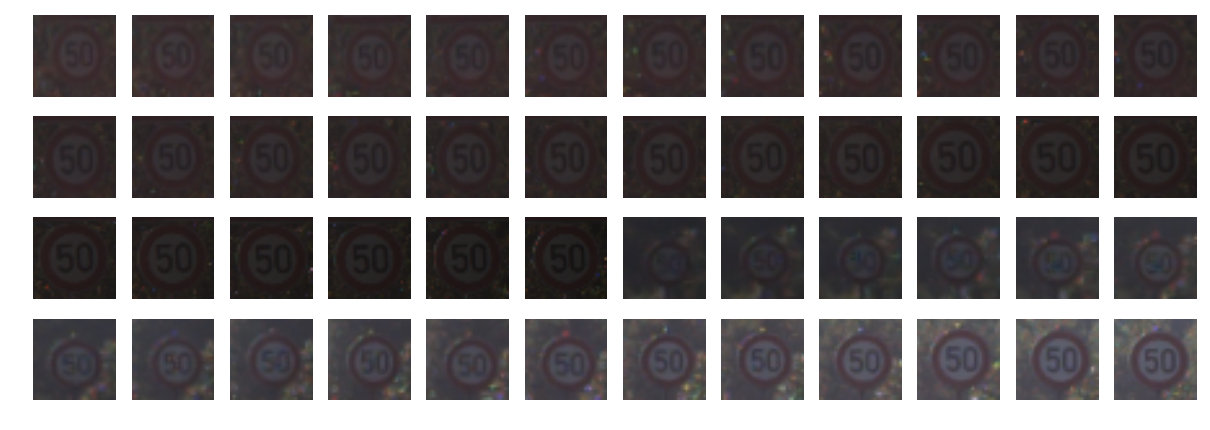

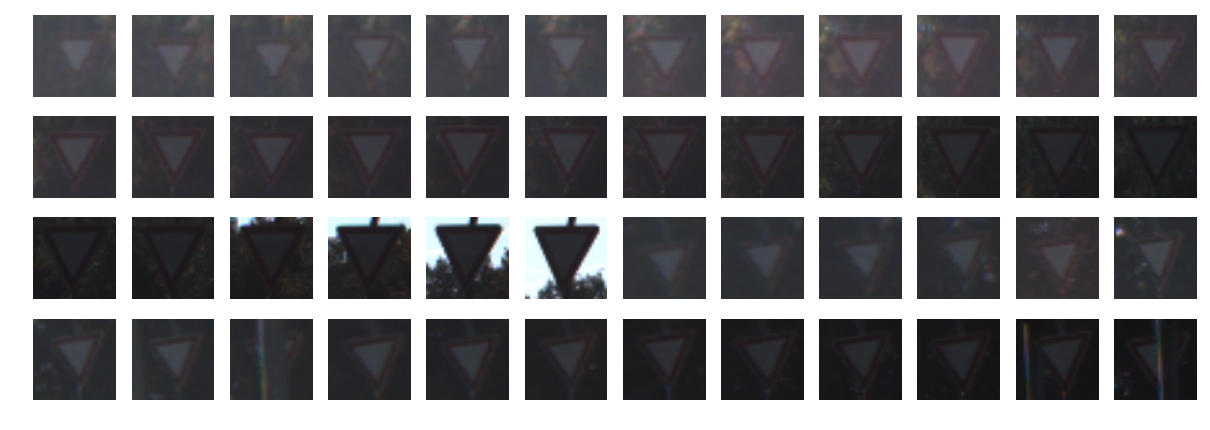

In [65]:
#variations in a class 
# Lets look at class 2
img_class(images, 2, "class_2.png" )
# and class 13
img_class(images,13, "class_13.png" )

###Above: Repetitions but variation of 1.scale 2.lighting 3.angle...

In [66]:
signnames = pd.read_csv('/home/octo/Desktop/signnames.csv')
data_i = [[i,sum(y_train == i)] for i in range(len(np.unique(y_train)))]
data_i_sorted = sorted(data_i, key=lambda x: x[1])
signnames['Occurance'] = pd.Series(np.asarray(data_i_sorted).T[1], index=np.asarray(data_i_sorted).T[0])
signnames_sorted =signnames.sort_values(['Occurance'],ascending=[0]).reset_index()
signnames_sorted =signnames_sorted.drop('index', 1)

import csv

sign_names = []
with open('/home/octo/Desktop/signnames.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        sign_names.append(row[1])
    sign_names.reverse()
    sign_names.pop()

In [67]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

num_x = 5
num_y = 5
fig, ax = plt.subplots(num_y,num_x)
fig.set_size_inches(10,15)
for i in range(num_x*num_y):
    n = random.random()*len(X_train)
    ax[int(i/num_x)][i%num_x].imshow(X_train[n])
    coords = c_train[n]
    rect = patches.Rectangle((coords[0],coords[1]),coords[2]-coords[0],coords[3]-coords[1],edgecolor='#00ff00',facecolor='none')
    ax[int(i/num_x)][i%num_x].add_patch(rect)
    ax[int(i/num_x)][i%num_x].set_title(sign_names[y_train[n]], fontsize=8)

plt.show()

"### Data exploration visualization goes here.\n### Feel free to use as many code cells as needed.\nimport matplotlib.pyplot as plt\nimport matplotlib.patches as patches\nimport random\n# Visualizations will be shown in the notebook.\n%matplotlib inline\n\nnum_x = 5\nnum_y = 5\nfig, ax = plt.subplots(num_y,num_x)\nfig.set_size_inches(10,15)\nfor i in range(num_x*num_y):\n    n = random.random()*len(X_train)\n    ax[int(i/num_x)][i%num_x].imshow(X_train[n])\n    coords = c_train[n]\n    rect = patches.Rectangle((coords[0],coords[1]),coords[2]-coords[0],coords[3]-coords[1],edgecolor='#00ff00',facecolor='none')\n    ax[int(i/num_x)][i%num_x].add_patch(rect)\n    ax[int(i/num_x)][i%num_x].set_title(sign_names[y_train[n]], fontsize=8)\n\nplt.show()"

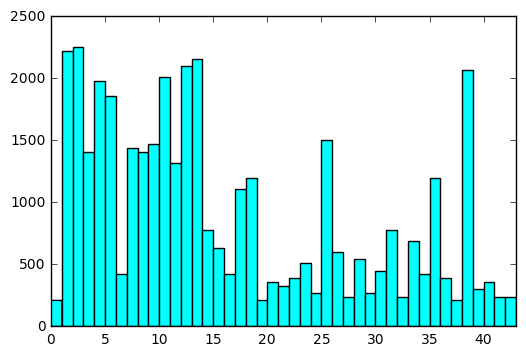

Maximum Occuring Traffic Sign in the data: End of no passing
Minimum Occuring Traffic Sign in the data: 


In [68]:
import numpy as np
hist_data = np.histogram(y_train,bins=range(44))
hist_map = {}
for occr,index in zip(hist_data[0],hist_data[1]):
    hist_map[occr]=index

plt.hist(y_train,bins=range(44),color='#00ffff')
plt.axis([0,43,0,2500])
plt.show()

print("Maximum Occuring Traffic Sign in the data: "+sign_names[hist_map[np.amax(hist_data[0])]])
print("Minimum Occuring Traffic Sign in the data: "+sign_names[hist_map[np.amin(hist_data[0])]])

In [2]:
#signnames_sorted.dropna()

In [70]:
def sign_class_name(class_id):
    return signnames[signnames['ClassId'] == class_id]['SignName'].iloc[0]

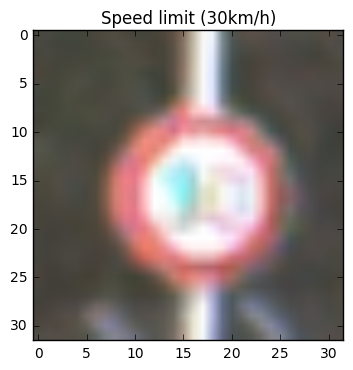

In [71]:
# Show one of the images
i = 1231
image = X_train[i]
plt.title(sign_class_name(y_train[i]))
plt.imshow(image)

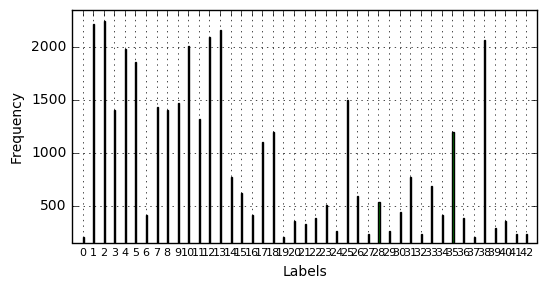

In [72]:
#histogram of each class.Higher deviation class wise
l = labels
x = list(set(l))
y = [l.count(i) for i in x]
width = 0.1
plt.figure(figsize=(6,3))
plt.xlabel('Labels')
plt.xticks(x, x, fontsize = 8)
plt.ylabel('Frequency')
plt.axis([min(x)-1,max(x)+1,min(y)-50,max(y)+100])
plt.grid(True)
plt.bar(x, y, width, color='g')
plt.show()

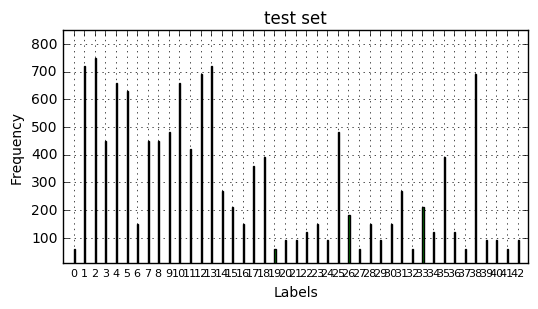

In [73]:
#Testing for test set
#This uneven frequencies/deviation, even in test set.
l = test['labels'].tolist()
x = list(set(l))
y = [l.count(i) for i in x]
width = 0.1
plt.figure(figsize=(6,3))
plt.xlabel('Labels')
plt.xticks(x, x, fontsize = 8)
plt.ylabel('Frequency')
plt.title('test set')
plt.axis([min(x)-1,max(x)+1,min(y)-50,max(y)+100])
plt.grid(True)

plt.bar(x, y, width, color='g')

plt.show()

[ 75  78  80  74  76  78  83  84  83 101  92  85 130 107 102 153 113 114
 173 114]


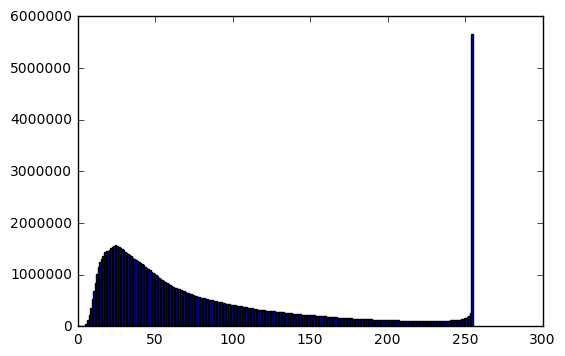

In [74]:
#distribution of color across all  flattened images
#### Few images near to 255 and large range for bew 75. Need to Normalize.

images = X_train
flattened = images.ravel()
print(flattened[:20])
plt.hist(flattened.ravel(),255);

In [75]:
#Compute mean and std deviation of all images and plot
mean_img = np.mean(images, axis=0)
std_img = np.std(images, axis=0)

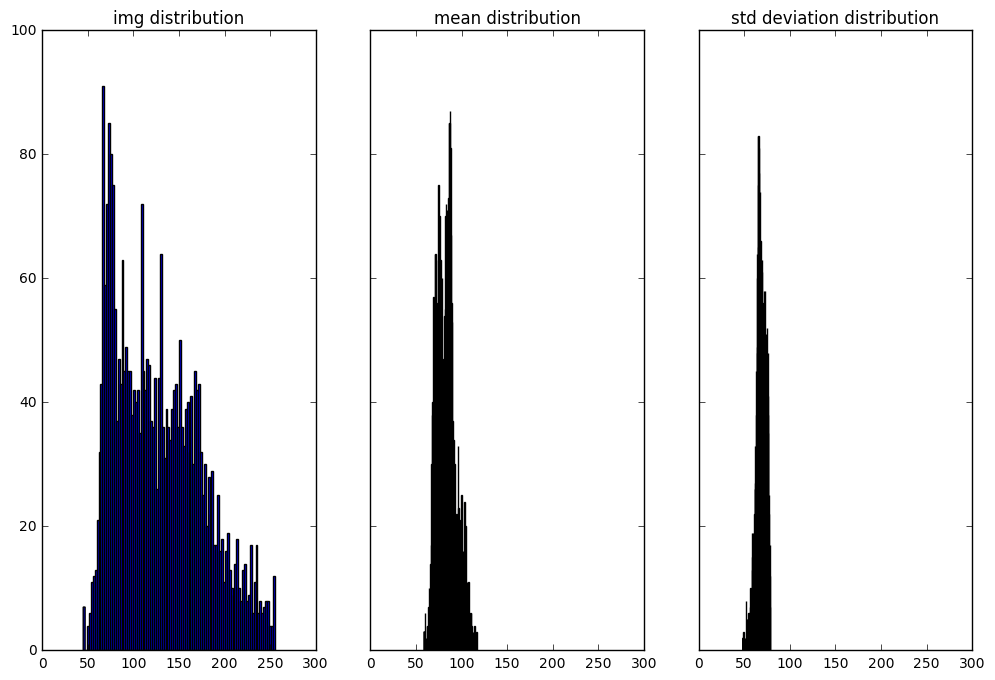

In [76]:
bins=100
fig,axs = plt.subplots(1,3, figsize=(12,8), sharey=True, sharex=True)
axs[0].hist((images[5]).ravel(), bins)
axs[0].set_title('img distribution')

axs[1].hist((mean_img).ravel(), bins)
axs[1].set_title('mean distribution')

axs[2].hist((std_img).ravel(), bins)
axs[2].set_title('std deviation distribution')

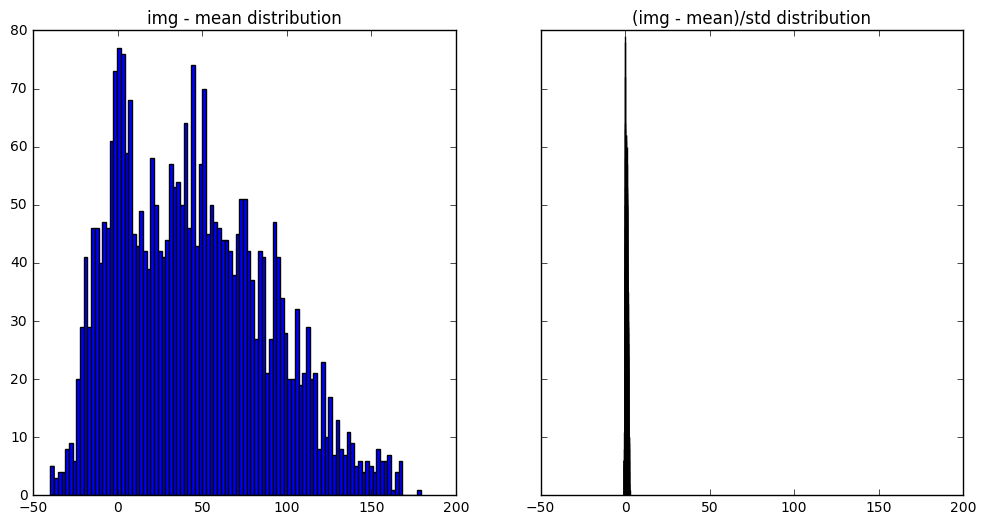

In [77]:
#effect of normalizing - data will be around 0.
#We need to preprocess like normalization of data before training
fig,axs = plt.subplots(1,2, figsize=(12,6), sharey=True, sharex=True)
axs[0].hist((images[5] - mean_img).ravel(), bins)
axs[0].set_title('img - mean distribution')

axs[1].hist(((images[5] - mean_img)/std_img).ravel(), bins)
axs[1].set_title('(img - mean)/std distribution')

In [78]:
#plt.imshow(X_train[12])
# From previously figures I think preprocessing like transformation is needed before training

slightly_translated = imutils.translate(X_train[12], 3, 0)
#plt.imshow(slightly_translated)
slightly_rotated = imutils.rotate(X_train[12], angle=20)
#plt.imshow(slightly_rotated)
slightly_scaled = imutils.resize(X_train[12], width=28)
slightly_scaled = imutils.resize(slightly_scaled, width=32)
#plt.imshow(slightly_scaled)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [79]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

#### Preprocess

Input of all these values directly into a network may lead to numerical overflows even functions like sigmoid activation are not compatible with these kinds of input and those neuron may saturate resulting  a poor job at learning. So preprocess is important. 

So I normalized the data so that the optimizer doesn't have a hard time and it can optimize quiker. 


In [80]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

#I compute the mean image of the training set and subtracted from the whole training set.
import numpy as np

X_train = np.array(X_train)
X_train = X_train/255

chann_index_swap = np.swapaxes(X_train,0,3)
mean_image = [[[sum(pixel)/len(pixel) for pixel in col] for col in row] for row in chann_index_swap]
mean_image = np.swapaxes(mean_image,0,2)
mean_image = np.swapaxes(mean_image,0,1)

X_train = X_train - mean_image

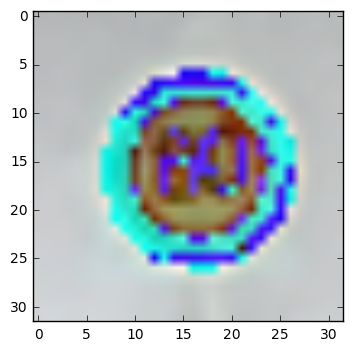

In [159]:
# After preprocessing
plt.imshow(X_train[25])

#### Genaration of Data

I mainly rotated, translated and resized data to generate extra data. Histogram equilization may be useful but not used here. Generation of additional data is very important, because some classes have a lot less examples than others. So generated data is different from the original data in that it is translated, rotated or scaled.

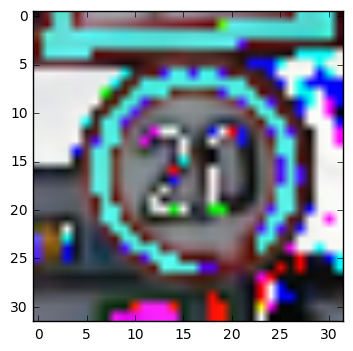

In [81]:
# Translation needed
plt.imshow(imutils.translate(X_train[15], 0, 0))#X_train[15], 0, 2

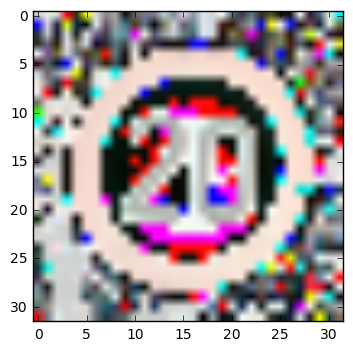

In [82]:
# rotation needed

plt.imshow(imutils.rotate(X_train[89], angle=0))#5

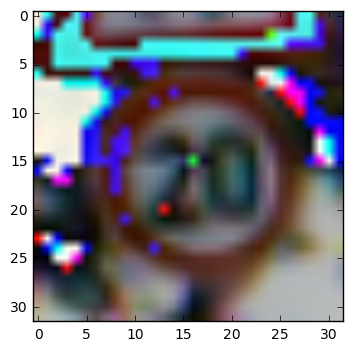

In [83]:
slightly_scaled = imutils.resize(imutils.resize(X_train[42], width=28), width=32)
plt.imshow(slightly_scaled)

In [84]:
#Based above cases these methods are made for further use
# Transorfmation: rotation, translation, scaling.Generation additional data
def scaling(X_train, y_train, width=29):
    X_train_scaled = np.zeros_like(X_train)
    for i in range(len(X_train)):
        temp = imutils.resize(X_train[i], width)
        X_train_scaled[i] = imutils.resize(temp, 32)
    return X_train_scaled, y_train

def translation(X_train, y_train, dx=3, dy=0):
    X_train_translated = np.zeros_like(X_train)
    for i in range(len(X_train)):
        X_train_translated[i] = imutils.translate(X_train[i], dx, dy)
    return X_train_translated, y_train

def rotation(X_train, y_train, rotation_angle=5):
    X_train_rotated = np.zeros_like(X_train)
    for i in range(len(X_train)):
        X_train_rotated[i] = imutils.rotate(X_train[i], rotation_angle)
    return X_train_rotated, y_train

In [85]:
#SPLIT:Validation Set 25%

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

1. Validation set by splitting the training set by 25%. Testing set already imported to begin.
2. 3 functions scaling(),translation() and rotation() are created above

In [86]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [87]:
def tf_TSC_model(x, drop_probablity):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Convolutional 32x32x3 -> 32x32x6
    c0_W = tf.Variable(tf.truncated_normal(shape=(1,1,3,6), mean = mu, stddev = sigma))
    c0_b = tf.Variable(tf.zeros(6))
    c0   = tf.nn.conv2d(x, c0_W, strides=[1, 1, 1, 1], padding='VALID') + c0_b

    # Relu Activation.
    c0 = tf.nn.relu(c0)
    print('Conv0 {}'.format(c0.get_shape()))
    
    # Convolutional 32x32x6 -> 28x28x6.
    c1_W = tf.Variable(tf.truncated_normal(shape=(5,5,6,6), mean = mu, stddev = sigma))
    c1_b = tf.Variable(tf.zeros(6))
    c1   = tf.nn.conv2d(c0, c1_W, strides=[1, 1, 1, 1], padding='VALID') + c1_b

    # Relu Activation.
    c1 = tf.nn.relu(c1)
        
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    c1 = tf.nn.max_pool(c1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    print('Conv1 {}'.format(c1.get_shape()))
    c1 = tf.nn.dropout(c1,drop_probablity)
    
    # Convolutional 14x14x6 -> 10x10x12
    c2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6,12), mean = mu, stddev = sigma))
    c2_b = tf.Variable(tf.zeros(12))
    c2   = tf.nn.conv2d(c1, c2_W, strides=[1, 1, 1, 1], padding='VALID') + c2_b
    
    # Relu Activation.
    c2 = tf.nn.relu(c2)
    print('Conv2 {}'.format(c2.get_shape()))
    
    c2 = tf.nn.dropout(c2,drop_probablity)

    
    # Convolutional 10x10x12 -> 8x8x24
    c3_W = tf.Variable(tf.truncated_normal(shape=(3,3,12,24), mean = mu, stddev = sigma))
    c3_b = tf.Variable(tf.zeros(24))
    c3   = tf.nn.conv2d(c2, c3_W, strides=[1, 1, 1, 1], padding='VALID') + c3_b
    
    # Relu Activation.
    c3 = tf.nn.relu(c3)
    print('Conv3 {}'.format(c3.get_shape()))
    c3 = tf.nn.dropout(c3,drop_probablity)
    
    # Convolutional 8x8x24 -> 6x6x48
    c4_W = tf.Variable(tf.truncated_normal(shape=(3,3,24,48), mean = mu, stddev = sigma))
    c4_b = tf.Variable(tf.zeros(48))
    c4 = tf.nn.conv2d(c3, c4_W, strides=[1, 1, 1, 1], padding='VALID') + c4_b
    
    # Relu Activation
    c4 = tf.nn.relu(c4)
    print('Conv4 {}'.format(c4.get_shape()))
    
    # Convolutional 6x6x48 -> 4x4x96
    c5_W = tf.Variable(tf.truncated_normal(shape=(3,3,48,96), mean = mu, stddev = sigma))
    c5_b = tf.Variable(tf.zeros(96))
    c5 = tf.nn.conv2d(c4, c5_W, strides=[1, 1, 1, 1], padding='VALID') + c5_b
    
    # Relu Activation
    c5 = tf.nn.relu(c5)
    print('Conv5 {}'.format(c5.get_shape()))
    
    # Convolutional 4x4x96 -> 2x2x182
    c6_W = tf.Variable(tf.truncated_normal(shape=(3,3,96,182), mean = mu, stddev = sigma))
    c6_b = tf.Variable(tf.zeros(182))
    c6 = tf.nn.conv2d(c5, c6_W, strides=[1, 1, 1, 1], padding='VALID') + c6_b
    
    # Relu Activation
    c6 = tf.nn.relu(c6)
    print('Conv6 {}'.format(c6.get_shape()))
    
    # Convolutional 2x2x182 -> 1x1x182
    c7_W = tf.Variable(tf.truncated_normal(shape=(2,2,182,182), mean = mu, stddev = sigma))
    c7_b = tf.Variable(tf.zeros(182))
    c7 = tf.nn.conv2d(c6, c7_W, strides=[1, 1, 1, 1], padding='VALID') + c7_b
    
    # Relu Activation
    c7 = tf.nn.relu(c7)

    print('Conv7 {}'.format(c7.get_shape()))

    # Flatten 1x1x182 ->182.
    f0   = flatten(c7)
    print('Fully connected 0: {}'.format(f0.get_shape()))
    
    # Fully connected 182 -> 150.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(182,150), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(150))
    fc1   = tf.matmul(f0, fc1_W) + fc1_b
    
    # Relu Activation.
    fc1    = tf.nn.relu(fc1)
    
    print('Fully connected 1: {}'.format(fc1.get_shape()))

    # Fully connected 150 ->118.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(150,118), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(118))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Relu Activation.
    fc2    = tf.nn.relu(fc2)
    
    print('Fully connected 2: {}'.format(fc2.get_shape()))

    # Fully Connected 118 ->43
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(118,43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    output = tf.matmul(fc2, fc3_W) + fc3_b
    
    print('Fully connected 3: {}'.format(output.get_shape()))
    
    return output

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

#### I used shape=(1,1,3,6),later shape=(5,5,6,6), shape=(3,3,12,24) etc. I incresed to get low level features. I used dropout probablit of 0.8 for dropout and maxpooling. Each cases single vector bias is added. 

#### I started with LeNet example and then different batch size, Epochs but I found better result with convolutional layer with dropout and maxpooing at begining. 

    Dropout in all cases 80%
    0 Convolutional layer: 32x32x3 -> 32x32x6 with Relu Activation.
    1 Convolutional layer: 32x32x6 -> 28x28x6 with Relu Activation.
                        # Pooling. Input = 28x28x6. Output = 14x14x6.
                        #Dropout
    2 Convolutional layer:14x14x6 -> 10x10x12 with Relu Activation.
                        #Dropout
    3 Convolutional layer:10x10x12 -> 8x8x24 with Relu Activation.
                        #Dropout
    4 Convolutional layer: 8x8x24 -> 6x6x48 with Relu Activation.
    5 Convolutional layer: 6x6x48 -> 4x4x96 with Relu Activation.
    6 Convolutional layer: 4x4x96 -> 2x2x182 with Relu Activation.
    7 Convolutional layer: 2x2x182 -> 1x1x182 with Relu Activation.
    Flatten 1x1x182 ->182.
    Fully connected 182 -> 150 with Relu Activation.
    Fully connected 150 ->118 with Relu Activation.
    Fully Connected 118 ->43 with Relu Activation, so output:43
    

In [88]:
### Train your model here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
x = tf.placeholder(tf.float32, (None, 32, 32, 3), name="x")
y = tf.placeholder(tf.int32, (None), name="y")
oh = tf.one_hot(y,43)
dropout_probablity = tf.placeholder(tf.float32, (), name="dropout_probablity")

rate = 0.001

logits = tf_TSC_model(x,dropout_probablity)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, oh)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
predicN = tf.equal(tf.argmax(logits, 1), tf.argmax(oh, 1))
operN = tf.reduce_mean(tf.cast(predicN, tf.float32))
actual = tf.argmax(oh, 1)

def evaluate_accuracy(X_data, y_data, sess):
    n = len(X_data)
    total_accuracy = 0
    ''' List of indexes and prediction of images gotten wrong by the network'''
    gotten_wrong_list = []
    
    gotten_wrong_index = 0
    
    for offset in range(0,n, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(operN, feed_dict={x: batch_x, y: batch_y,dropout_probablity:1.0})
        pred = sess.run(predicN, feed_dict={x:batch_x, y:batch_y,dropout_probablity:1.0})
        act = sess.run(actual, feed_dict={y:batch_y,dropout_probablity:1.0})
        total_accuracy += (accuracy * len(batch_x))
        for a,b in zip(pred,act):
            if(not a == b):
                gotten_wrong_list.append((gotten_wrong_index,a))
            gotten_wrong_index = gotten_wrong_index+1
        total_accuracy += (accuracy * len(batch_x))
    return (total_accuracy / n), gotten_wrong_list

Conv0 (?, 32, 32, 6)
Conv1 (?, 14, 14, 6)
Conv2 (?, 10, 10, 12)
Conv3 (?, 8, 8, 24)
Conv4 (?, 6, 6, 48)
Conv5 (?, 4, 4, 96)
Conv6 (?, 2, 2, 182)
Conv7 (?, 1, 1, 182)
Fully connected 0: (?, 182)
Fully connected 1: (?, 150)
Fully connected 2: (?, 118)
Fully connected 3: (?, 43)


In [89]:
EPOCHS =3
BATCH_SIZE = 20
tf.add_to_collection('I', x)
tf.add_to_collection('I', y)
tf.add_to_collection('I',oh)
tf.add_to_collection('I',dropout_probablity)
tf.add_to_collection('O', logits)
tf.add_to_collection('O', predicN)
tf.add_to_collection('O', operN)

se = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n = len(X_train)
    
    print("\nTraining")
    print("Started....")
    
    best_validation_accuracy = 0
    for i in range(EPOCHS):
        se = time.time()
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, n, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            dp = 0.8
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, dropout_probablity:dp})
            
            for sc in range(2):
                rescaled_x, rescaled_y = scaling(batch_x, batch_y, 32 - (sc*2+1))
                sess.run(training_operation, feed_dict={x: rescaled_x, y:rescaled_y, 
                                                        dropout_probablity:dp})
            for t in range(-1, 2):
                translated_x, translated_y = translation(batch_x, batch_y, t*2)
                sess.run(training_operation, feed_dict={x: translated_x, y: translated_y, 
                                                        dropout_probablity: dp})
                
            for t in range(-1, 2):
                translated_x, translated_y = translation(batch_x, batch_y, 0, t*2)
                sess.run(training_operation, feed_dict={x: translated_x, y: translated_y,
                                                       dropout_probablity: dp})
            
            for ro in range(-1, 2):
                rotated_x, rotated_y = rotation(batch_x, batch_y, ro*2)
                sess.run(training_operation, feed_dict={x: rotated_x, y: rotated_y,
                                                       dropout_probablity:dp})
       
        validation_accuracy,gotten_wrong_list = evaluate_accuracy(X_validation, y_validation, sess)
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            try:
                saver
            except NameError:
                saver = tf.train.Saver()
            saver.save(sess, 'tf_TSC_model1')
            
            print("|tf_TSC_model1| model saved")
        
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Time for epoch: {}".format(time.time() - se))
        
        
    test_accuracy,gotten_wrong_list = evaluate_accuracy(X_test, y_test, sess)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

    
print("Time for all session: {}".format(time.time() - se))


Training
Started....
|tf_TSC_model1| model saved
EPOCH 1 ...
Validation Accuracy = 1.711
Time for epoch: 40.651270627975464
|tf_TSC_model1| model saved
EPOCH 2 ...
Validation Accuracy = 1.831
Time for epoch: 42.53534960746765
|tf_TSC_model1| model saved
EPOCH 3 ...
Validation Accuracy = 1.877
Time for epoch: 44.30147647857666
Test Accuracy = 1.526
Time for all session: 55.929133892059326


In [92]:
# Tesing on test data using saved model 'tf_TSC_model'
with tf.Graph().as_default() as g:
    with tf.Session() as sess:
        loader = tf.train.import_meta_graph('/home/octo/Desktop/tf_TSC_model1.meta')
        x, y, oh,dropout_probablity= tf.get_collection('I')[:4]
        logits,predicN,operN = tf.get_collection('O')[:3]
        loader.restore(sess, tf.train.latest_checkpoint('./'))
        print("Test Accuracy: = {:.3f}".format(evaluate_accuracy(X_test, y_test, sess)))
    


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

#### Optimization : 
I used tf.train.AdamOptimizer
#### Epochs :
For this model I tried with higher Epochs but result did not improve after 3 or 4. So I train with 3. 
#### Hyperparameters: 
Learning rate0.001, batch size of 20. For tf.truncated_normal() function I used 0 mean and 0.1 standard deviation. 
#### Training/validation data:
25% of training data used for validation. 

#### Preprocessing:
Translation by  +2, or -2 on the x axis and Rotation by +2 or -2 degrees.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**



1. I trained LeNet with training and valudation data. Got nearly 90% result. So I tried to achive above 95%.
2. After normalization accuracy imporved
3. Then tried 7 convolutional layers with drop out, max pooling, flatening and followed by the same fully connected layers as in LeNet
4. After than I tried with image augmentation functions by rotation, translation of images.
5. Later application of dropout by 80% drop probablity helped a lot.
6. Batch size started with above 100 but later I reduced based on frequency of each class. 

6th step took time for adjustment if batch and Epochs but lastly all those steps helped me to reach 97% above accuracy. 

Reference other than classes used:

https://github.com/rndbrtrnd/udacity-deep-learning

https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb

https://arxiv.org/abs/1606.02228

http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/#second-model-convolutions

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

* Plotting **5** out of the images gotten wrong by the network.

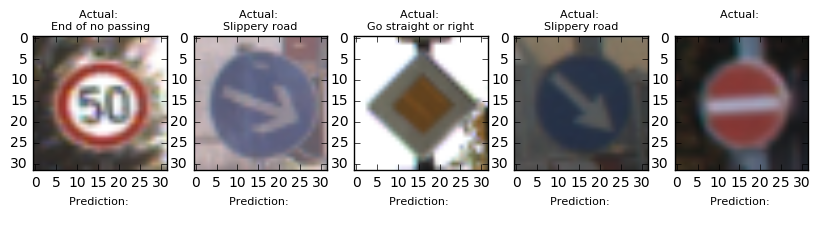

In [105]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

%matplotlib inline

num_x = 5
num_y = 1
fig, ax = plt.subplots(num_y,num_x)
fig.set_size_inches(10,10)
for i in range(num_x*num_y):
    n = random.random()*len(gotten_wrong_list)
    
    ax[i].imshow(X_test[gotten_wrong_list[int(n)][0]])
    
    ax[i].set_title("Actual: \n"+sign_names[y_test[gotten_wrong_list[int(n)][0]]],fontsize=8)
    ax[i].set_xlabel("Prediction: \n"+sign_names[gotten_wrong_list[int(n)][1]],fontsize=8)

plt.show()

##### Above error due to the low resolution of the images, blurry, or faded. This model predicts images that occur more frequently in the dataset as can be seen from the histogram above.
#### Above End of no pasing is wrongly predicted to Speed Limit 50. End of no pasing has frequency of 240 only.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


In [141]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

#### I have piceked up 30 impages randomly from training set. Then I compared the output manually and I have used signnames.csv for comparing. I found 25 out of 30 images are correctly predicted. This testing accuracy is 81% which is lower than 92% as tested with test data mainly I think due to (1) training (2) overfitting and (3)model ( AlexNet is better than LeNet).  

In [163]:
signnames_sorted.dropna().head(3)

ClassId                     SignName  Occurance
1      0.0         Speed limit (20km/h)     2220.0
2      6.0  End of speed limit (80km/h)     2160.0
7      2.0         Speed limit (50km/h)     1860.0

In [164]:
# Pick 30 random images
sample_indexes = random.sample(range(len(X_train)), 30)
sample_images = [X_train[i] for i in sample_indexes]
sample_labels = [y_train[i] for i in sample_indexes]

In [116]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Graph().as_default() as g:
    with tf.Session() as sess:
        loader = tf.train.import_meta_graph('/home/octo/Desktop/tf_TSC_model1.meta')
        x, y, oh,dropout_probablity= tf.get_collection('I')[:4]
        logits,predicN,operN = tf.get_collection('O')[:3]
        loader.restore(sess, tf.train.latest_checkpoint('./'))
        best5 = tf.nn.top_k(tf.nn.softmax(logits), 5)
        output = sess.run(best5, feed_dict={x:sample_images, y:sample_labels,dropout_probablity: 1.0})
        pred_best_5 = output.values
        best5_indices = output.indices
        
        
        for i in range(len(pred_best_5)):
            print('Example {i} -> {actual}'.format(i=i, actual=sign_class_name(sample_labels[i])))
            for j in range(5):
                traffic_sign = sign_class_name(best5_indices[i][j])
                probability = pred_best_5[i][j]
                print("#>{traffic_sign} -> {probability}".format(traffic_sign=traffic_sign, 
                                                                     probability=probability))
        print("Test Accuracy: = {:.3f}".format(evaluate_accuracy(X_test, y_test, sess)))
 

Example 0 -> Speed limit (50km/h)
#>Dangerous curve to the right -> 0.024332556873559952
#>No vehicles -> 0.023912930861115456
#>Go straight or left -> 0.02389785833656788
#>Traffic signals -> 0.02389254979789257
#>Road work -> 0.023767530918121338
Example 1 -> Slippery road
#>Dangerous curve to the right -> 0.024242829531431198
#>Go straight or left -> 0.023959625512361526
#>Traffic signals -> 0.023825399577617645
#>No vehicles -> 0.02371245250105858
#>Road work -> 0.023635419085621834
Example 2 -> Yield
#>Dangerous curve to the right -> 0.024358028545975685
#>Traffic signals -> 0.0239036176353693
#>No vehicles -> 0.023901520296931267
#>Go straight or left -> 0.023869162425398827
#>Road work -> 0.023759102448821068
Example 3 -> No entry
#>Dangerous curve to the right -> 0.024293364956974983
#>Go straight or left -> 0.02394360676407814
#>Traffic signals -> 0.02381867542862892
#>No vehicles -> 0.023769626393914223
#>Speed limit (60km/h) -> 0.023711634799838066
Example 4 -> Speed limit (

**Answer:**

In [135]:
X_test_norm = X_test/255
X_test_norm = X_test_norm - mean_image

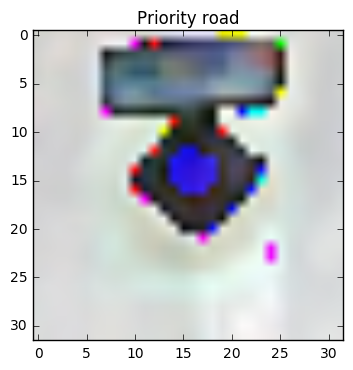

In [136]:
# Show one of the images
i = 3897
image = X_train[i]
plt.title(sign_class_name(y_train[i]))
plt.imshow(image)

2


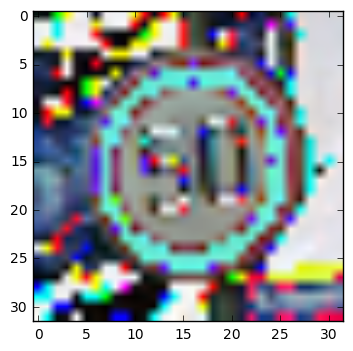

In [137]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

#plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])
#plt.imsave("spped30.jpg",train['features'][45])

In [139]:
print(sample_labels)

[2, 13, 34, 13, 25, 18, 29, 25, 3, 1, 23, 9, 12, 11, 4, 17, 30, 12, 11, 18, 13, 2, 0, 10, 13, 38, 12, 12, 2, 11]


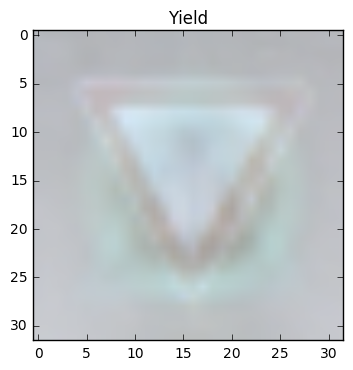

In [140]:
plt.title(sign_class_name(sample_labels[20]))
plt.imshow(sample_images[20])

####Manual checking using signnames.csv

#### model predicted 24 out 30 signs correctly, it's 81% accurate.

Example 0 -> Right-of-way at the next intersection
#>Right-of-way at the next intersection -> 1.0

Example 1 -> Speed limit (30km/h)
#>Speed limit (30km/h) -> 0.9974532723426819

Example 2 -> Ahead only
#>Ahead only -> 1.0

Example 3 -> Road work
#>Road work -> 1.0

Example 4 -> General caution
#>General caution -> 1.0

Example 5 -> Bicycles crossing
#>Bicycles crossing -> 0.990509033203125

Example 6 -> Go straight or right
#>Go straight or right -> 1.0

Example 7 -> Speed limit (80km/h)
#>Speed limit (80km/h) -> 0.999930739402771

Example 8 -> Slippery road
#>Slippery road -> 1.0

Example 9 -> No passing
#>No passing -> 1.0

Example 10 -> No passing for vehicles over 3.5 metric tons
#>No passing for vehicles over 3.5 metric tons -> 0.9999947547912598

Example 11 -> Keep right
#>Keep right -> 1.0

Example 12 -> Speed limit (120km/h)
#>Speed limit (120km/h) -> 0.9999953508377075

Example 13 -> Speed limit (50km/h)
#>Speed limit (50km/h) -> 0.9987867474555969

Example 14 -> Road work
#>Road work -> 1.0

Example 15 -> Wild animals crossing
#>Wild animals crossing -> 0.9999926090240479

Example 16 -> End of all speed and passing limits
#>End of all speed and passing limits -> 0.969563364982605

Example 17 -> Ahead only
#>Ahead only -> 1.0

Example 18 -> No vehicles
#>No vehicles -> 0.9999233484268188

Example 19 -> Bicycles crossing
#>Bicycles crossing -> 0.9962336421012878

Example 20 -> Road work
#>Road work -> 1.0

Example 21 -> Speed limit (50km/h)
#>Speed limit (50km/h) -> 0.9999456405639648

Example 22 -> Road work
#>Road work -> 1.0

Example 23 -> General caution
#>General caution -> 0.9832806587219238

Example 24 -> Speed limit (70km/h)
#>Speed limit (70km/h) -> 0.999997615814209

Example 25 -> No passing
#>No passing -> 1.0

In [108]:
from matplotlib.image import imread
custom_images = []

for i in range(15):
    custom_images.append(imread("/home/octo/Desktop/add_pics/image"+str(i)+".jpg",))

In [126]:
# Read Images
im1 = imread("/home/octo/Desktop/add_pics/image1.jpg").astype(np.float32)
im1 = im1 - np.mean(im1)

im2 = imread("/home/octo/Desktop/add_pics/image2.jpg").astype(np.float32)
im2 = im2 - np.mean(im2)

In [146]:
resized = tf.image.resize_images(im1, (32,32))

In [147]:
X_test_custom = np.array(resized)/255
X_test_custom = X_test_custom - mean_image

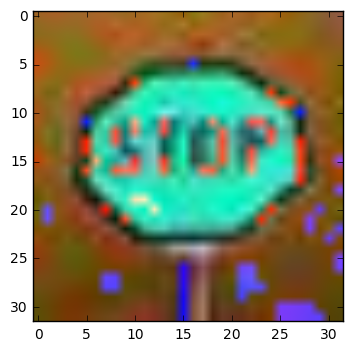

In [148]:
plt.imshow(im1)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.


**Answer:**

 #### tf.nn.top_k(tf.nn.softmax(logits), 5)
 
 Above softmax function is used in side tf.nn.top_k() is used to get top 5 candidate  

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.